In [49]:
#импорт библиотек
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

%matplotlib inline
plt.style.use('seaborn')


C:\Users\sesha\AppData\Local\Temp\ipykernel_20112\1599475198.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [50]:
!pip install hyperopt


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

In [52]:
!pip install optuna


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
import optuna

In [54]:
data = pd.read_csv('_train_sem09__1_.zip')
data=data.copy()

In [55]:
print(data.shape)
data.head()

(3751, 1777)


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверим сбалансированность целевого признака:

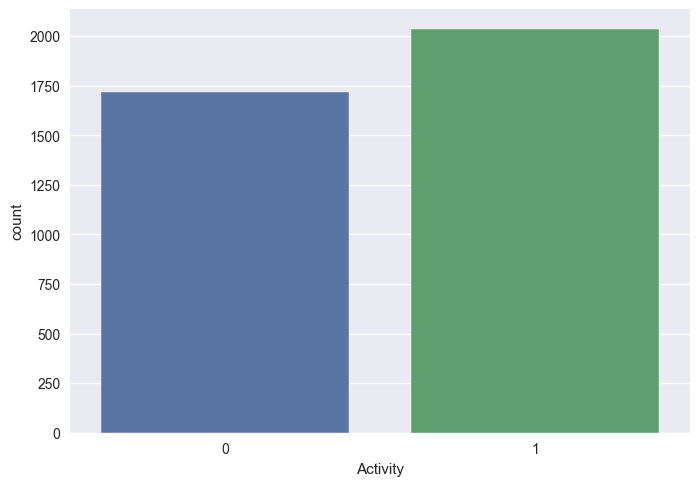

In [56]:
sns.countplot(data=data, x='Activity');
# Признак вполне сбалансирован

# Обучение модели

In [57]:
# Создаем матрицу наблюдений x и вектор ответов y
X = data.drop(['Activity'], axis=1)
y = data['Activity']
# Разделяем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y, 
    random_state = 42, 
    test_size = 0.2)

# Логистическая регрессия

In [58]:
# Обучим модель без дополнительных надстроек
log_reg = linear_model.LogisticRegression(max_iter = 50, random_state = 42)

log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)

print('f1_score логистической регрессии без надстроек: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score логистической регрессии без надстроек: 0.78


c:\Users\sesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Используем класс GridSearchCV для поиска гиперпараметров

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,
        max_iter=50
    ), 
    param_grid=param_grid, 
    scoring='f1', # задаём метрику
    cv=5, # устанавливаем количество фолдов в кросс-валидации
    n_jobs = -1
) 

grid_search.fit(X_train, y_train) 
y_test_pred_grid = grid_search.predict(X_test)

c:\Users\sesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [60]:
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_grid)))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))
print()
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

f1_score на тестовом наборе: 0.79
Наилучшее значение точности при кросс-валидаци: 0.79

Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}
Наилучшая модель:
LogisticRegression(C=0.3, max_iter=50, penalty='l1', random_state=42,
                   solver='saga')


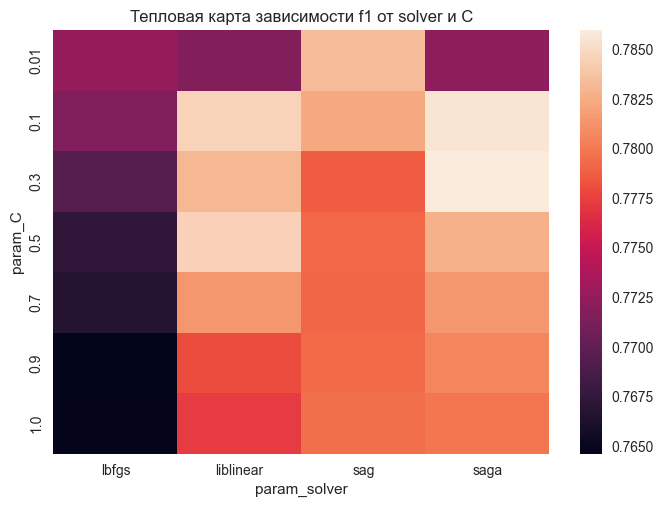

In [61]:
# Визуализируем зависимость f1_score от solver и С
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости f1 от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) 

Лучшие значения метрики получаем при:  
регуляризации С = 0.1 и 0.3  
алгоритм оптимизации: saga

Теперь тспользуем класс RandomizedSearchCV для подбора гиперпараметров

In [62]:
from sklearn.model_selection import RandomizedSearchCV


param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    scoring='f1', # задаём метрику
    cv=5, # устанавливаем количество фолдов в кросс-валидации
    n_iter = 10, 
    n_jobs = -1
)  
random_search.fit(X_train, y_train) 
y_test_pred_random = random_search.predict(X_test)

c:\Users\sesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [63]:
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_random)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}


### RandomForestClassifier

In [64]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 

y_test_pred_forest = rf.predict(X_test)
print('f1_score RandomForestClassifier без надстроек: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_forest)))

f1_score RandomForestClassifier без надстроек: 0.80


### Поиск параметров с помощью Байесовской оптимизации

#### Библиотека для оптимизации гиперпараметров Hyperopt 

In [65]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      } 

In [66]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=42)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    return -score

In [67]:
trials = Trials()
best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=50, # максимальное количество итераций
          trials=trials,
          rstate=np.random.default_rng(42)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [02:47<00:00,  3.35s/trial, best loss: -0.9917101627264354]
Наилучшие значения гиперпараметров {'max_depth': 26.0, 'min_samples_leaf': 2.0, 'n_estimators': 199.0}


In [68]:

model_hyperopt = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model_hyperopt.fit(X_train, y_train)

y_test_pred_hyperopt = model_hyperopt.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_hyperopt)))

f1_score на тестовом наборе: 0.80


#### Библиотека для оптимизации гиперпараметров Optuna 

In [69]:
def optuna_rf(trial):

  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [71]:
study = optuna.create_study(study_name="RandomForestClassifier", 
                            direction="maximize"
                            )
study.optimize(optuna_rf, n_trials=25)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2023-09-16 18:51:04,346] A new study created in memory with name: RandomForestClassifier
[I 2023-09-16 18:51:07,651] Trial 0 finished with value: 0.9193993257738278 and parameters: {'n_estimators': 153, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9193993257738278.
[I 2023-09-16 18:51:12,218] Trial 1 finished with value: 0.9746719560573696 and parameters: {'n_estimators': 190, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9746719560573696.
[I 2023-09-16 18:51:14,583] Trial 2 finished with value: 0.8901098901098902 and parameters: {'n_estimators': 146, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9746719560573696.
[I 2023-09-16 18:51:16,848] Trial 3 finished with value: 0.891317547055252 and parameters: {'n_estimators': 132, 'max_depth': 14, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9746719560573696.
[I 2023-09-16 18:51:19,443] Trial 4 finished with value: 0.9220503488019411 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 172, 'max_depth': 22, 'min_samples_leaf': 2}


In [73]:
model_optuna = ensemble.RandomForestClassifier(**study.best_params,
                                               random_state=42)
model_optuna.fit(X_train, y_train)

y_test_pred = model_optuna.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


In [75]:
# Визуализируем связь параметров
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

In [76]:
optuna.visualization.plot_contour(study, params=["max_depth", "min_samples_leaf"],
                                  target_name="f1_score")

In [77]:
optuna.visualization.plot_contour(study, params=["n_estimators", "min_samples_leaf"],
                                  target_name="f1_score")